In [39]:
from dsd import DATA_DIR 
from dsd.sam_similarity_diffusion_rendered import calculate_similarities_for_renders, load_sam_model
sam_predictor = load_sam_model()

render_dataset = DATA_DIR / "diffusion_renders" / "mugs" / "run_1"
similarity_dict = calculate_similarities_for_renders(render_dataset, sam_predictor)


  0%|          | 0/100 [00:00<?, ?it/s]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/018/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/018/ControlnetfromHEDRenderer/an orange mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/018/ControlNetFromNormalsRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/018/ControlNetFromNormalsRenderer/ a coffee mug_2.png because it is all black
skipping /fast_stor

  1%|          | 1/100 [00:20<33:47, 20.48s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/013/ControlNetFromNormalsRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/013/ControlNetFromCannyRenderer/a mug on a surface_3.png because it is all black


  2%|▏         | 2/100 [00:41<34:16, 20.99s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/009/ControlnetfromHEDRenderer/a cup on a table_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/009/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/009/ControlnetfromHEDRenderer/a blue mug on a metallic surface_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/009/ControlnetfromHEDRenderer/a mug with a picture of a dog_3.png because it is

  3%|▎         | 3/100 [01:02<33:30, 20.72s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/003/ControlnetfromHEDRenderer/a blue mug on a metallic surface_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/003/ControlNetFromDepthRenderer/a blue mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/003/ControlNetFromDepthRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/003/ControlNetFromDepthRenderer/a mug on a table_0.png because it is all black
sk

  4%|▍         | 4/100 [01:23<33:13, 20.76s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/014/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/014/ControlnetfromHEDRenderer/a colorful mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/014/ControlnetfromHEDRenderer/a mug on a table_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/014/ControlNetFromNormalsRenderer/ a coffee mug_3.png because it is all bl

  5%|▌         | 5/100 [01:43<32:42, 20.65s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/005/ControlNetFromNormalsRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/005/ControlNetFromDepthRenderer/ a mug_0.png because it is all black


  6%|▌         | 6/100 [02:04<32:45, 20.91s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/019/ControlNetFromNormalsRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/019/ControlNetFromNormalsRenderer/a cup on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/019/ControlNetFromNormalsRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/019/ControlNetFromNormalsRenderer/ a coffee mug_1.png because it is all black
skipping

  7%|▋         | 7/100 [02:25<32:24, 20.90s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/011/ControlnetfromHEDRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/011/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/011/ControlnetfromHEDRenderer/a cup_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/011/ControlNetFromNormalsRenderer/ a coffee mug_3.png because it is all black
skipping

  8%|▊         | 8/100 [02:47<32:23, 21.12s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/012/ControlnetfromHEDRenderer/a blue mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/012/ControlnetfromHEDRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/012/ControlnetfromHEDRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/012/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
sk

  9%|▉         | 9/100 [03:05<30:32, 20.13s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/007/ControlnetfromHEDRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/007/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/007/ControlnetfromHEDRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/007/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
s

 10%|█         | 10/100 [03:25<30:00, 20.00s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/000/ControlnetfromHEDRenderer/a mug on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/000/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/000/ControlNetFromCannyRenderer/a mug with a picture of a dog_0.png because it is all black


 11%|█         | 11/100 [03:46<30:23, 20.48s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/002/ControlnetfromHEDRenderer/a cup_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/002/ControlnetfromHEDRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/002/ControlNetFromNormalsRenderer/a blue mug on a metallic surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/002/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
ski

 12%|█▏        | 12/100 [04:06<29:54, 20.40s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/017/ControlnetfromHEDRenderer/a blue mug on a metallic surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/017/ControlnetfromHEDRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/017/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/017/ControlnetfromHEDRenderer/a blue mug_2.png because it is all black
skipping /f

 13%|█▎        | 13/100 [04:24<28:19, 19.53s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/016/ControlNetFromNormalsRenderer/a mug on a table_1.png because it is all black


 14%|█▍        | 14/100 [04:46<28:59, 20.23s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/010/ControlnetfromHEDRenderer/a mug on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/010/ControlnetfromHEDRenderer/a mug with a picture of a dog_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/010/ControlnetfromHEDRenderer/a mug on a surface_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/010/ControlnetfromHEDRenderer/ a mug_2.png because it is all black
ski

 15%|█▌        | 15/100 [05:04<27:50, 19.65s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/004/ControlnetfromHEDRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/004/ControlnetfromHEDRenderer/a blue mug on a metallic surface_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/004/ControlnetfromHEDRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/004/ControlnetfromHEDRenderer/ a coffee mug_1.png because it is all black
skipping

 16%|█▌        | 16/100 [05:23<27:12, 19.44s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/015/ControlnetfromHEDRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/015/ControlnetfromHEDRenderer/a colorful mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/015/ControlnetfromHEDRenderer/ a mug_2.png because it is all black


 17%|█▋        | 17/100 [05:44<27:43, 20.05s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/008/ControlnetfromHEDRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/008/ControlnetfromHEDRenderer/a mug with a picture of a dog_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/008/ControlNetFromNormalsRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/008/ControlNetFromNormalsRenderer/a cup_2.png because it is all black

 18%|█▊        | 18/100 [06:05<27:35, 20.19s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/006/ControlnetfromHEDRenderer/a mug with a picture of a dog_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/006/ControlNetFromNormalsRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/006/ControlNetFromNormalsRenderer/a cup_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/006/ControlNetFromNormalsRenderer/a cup on a table_0.png becau

 19%|█▉        | 19/100 [06:24<26:48, 19.86s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/001/ControlnetfromHEDRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/001/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/001/ControlNetFromNormalsRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Threshold_porcelain_Coffee_Mug_All_over_bead/001/ControlNetFromCannyRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/s

 20%|██        | 20/100 [06:45<26:52, 20.16s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/018/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/018/ControlnetfromHEDRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/018/ControlnetfromHEDRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/018/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/da

 21%|██        | 21/100 [07:02<25:26, 19.33s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/013/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/013/ControlNetFromNormalsRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/013/ControlNetFromDepthRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/013/ControlNetFromCannyRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_rende

 22%|██▏       | 22/100 [07:23<25:45, 19.82s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/009/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/009/ControlnetfromHEDRenderer/an orange mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/009/ControlnetfromHEDRenderer/a mug on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/009/ControlnetfromHEDRenderer/ a coffee mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_rende

 23%|██▎       | 23/100 [07:43<25:16, 19.69s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/003/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/003/ControlnetfromHEDRenderer/a colorful mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/003/ControlnetfromHEDRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/003/ControlnetfromHEDRenderer/a blue mug on a metallic surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffu

 24%|██▍       | 24/100 [08:01<24:27, 19.31s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/014/ControlnetfromHEDRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/014/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/014/ControlnetfromHEDRenderer/a blue mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/014/ControlnetfromHEDRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_r

 25%|██▌       | 25/100 [08:19<23:44, 18.99s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/005/ControlnetfromHEDRenderer/a blue mug on a metallic surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/005/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/005/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/005/ControlnetfromHEDRenderer/a mug with a picture of a dog_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documen

 26%|██▌       | 26/100 [08:36<22:37, 18.35s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/019/ControlnetfromHEDRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/019/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/019/ControlnetfromHEDRenderer/a cup_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/019/ControlnetfromHEDRenderer/ a coffee mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/dif

 27%|██▋       | 27/100 [08:56<22:53, 18.82s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/011/ControlNetFromNormalsRenderer/a blue mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/011/ControlNetFromNormalsRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/011/ControlNetFromNormalsRenderer/a mug on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/011/ControlNetFromNormalsRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion

 28%|██▊       | 28/100 [09:16<23:05, 19.25s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/012/ControlnetfromHEDRenderer/a blue mug on a metallic surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/012/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/012/ControlnetfromHEDRenderer/a colorful mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/012/ControlnetfromHEDRenderer/a blue mug on a metallic surface_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing

 29%|██▉       | 29/100 [09:35<22:43, 19.21s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/007/ControlNetFromNormalsRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/007/ControlNetFromNormalsRenderer/a colorful mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/007/ControlNetFromNormalsRenderer/ a mug_2.png because it is all black


 30%|███       | 30/100 [09:57<23:10, 19.86s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/000/ControlnetfromHEDRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/000/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/000/ControlnetfromHEDRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/000/ControlNetFromNormalsRenderer/a blue mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/m

 31%|███       | 31/100 [10:16<22:30, 19.58s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/002/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/002/ControlnetfromHEDRenderer/a cup on a table_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/002/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/002/ControlnetfromHEDRenderer/a mug with a picture of a dog_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffus

 32%|███▏      | 32/100 [10:34<21:37, 19.07s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/017/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/017/ControlNetFromDepthRenderer/ a mug_1.png because it is all black


 34%|███▍      | 34/100 [11:17<22:32, 20.49s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/010/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/010/ControlNetFromNormalsRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/010/ControlNetFromNormalsRenderer/an orange mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/010/ControlNetFromNormalsRenderer/a blue mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diff

 35%|███▌      | 35/100 [11:38<22:10, 20.46s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/004/ControlnetfromHEDRenderer/a blue mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/004/ControlnetfromHEDRenderer/a blue mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/004/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/004/ControlNetFromNormalsRenderer/a blue mug on a metallic surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusin

 36%|███▌      | 36/100 [11:56<21:03, 19.75s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/015/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/015/ControlNetFromNormalsRenderer/a cup_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/015/ControlNetFromNormalsRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/015/ControlNetFromDepthRenderer/a mug on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_render

 37%|███▋      | 37/100 [12:16<20:56, 19.95s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/015/ControlNetFromCannyRenderer/a mug on a table_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/008/ControlnetfromHEDRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/008/ControlnetfromHEDRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/008/ControlnetfromHEDRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/d

 38%|███▊      | 38/100 [12:35<20:19, 19.66s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/008/ControlNetFromCannyRenderer/a mug on a table_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/006/ControlnetfromHEDRenderer/a blue mug on a metallic surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/006/ControlnetfromHEDRenderer/a blue mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/006/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/da

 39%|███▉      | 39/100 [12:53<19:28, 19.15s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/001/ControlNetFromNormalsRenderer/a mug on a table_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/001/ControlNetFromCannyRenderer/a cup on a table_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/ACE_Coffee_Mug_Kristen/001/ControlNetFromCannyRenderer/ a mug_2.png because it is all black


 40%|████      | 40/100 [13:15<19:49, 19.83s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/018/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/018/ControlnetfromHEDRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/018/ControlnetfromHEDRenderer/a colorful mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/018/ControlnetfromHEDRenderer/a cup_0.png because it is all black
skipp

 41%|████      | 41/100 [13:33<19:10, 19.50s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/013/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/013/ControlnetfromHEDRenderer/a cup_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/013/ControlNetFromNormalsRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/013/ControlNetFromNormalsRenderer/a mug on a surface_1.png

 42%|████▏     | 42/100 [13:54<19:06, 19.77s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/009/ControlNetFromNormalsRenderer/a mug with a picture of a dog_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/009/ControlNetFromNormalsRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/009/ControlNetFromNormalsRenderer/ a coffee mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/009/ControlNetFromNormalsRenderer/ a mug_2.png be

 43%|████▎     | 43/100 [14:15<19:08, 20.15s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/003/ControlnetfromHEDRenderer/an orange mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/003/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/003/ControlNetFromNormalsRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/003/ControlNetFromNormalsRenderer/a mug on a surface_3.png becau

 44%|████▍     | 44/100 [14:35<18:45, 20.10s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/014/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/014/ControlnetfromHEDRenderer/a colorful mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/014/ControlnetfromHEDRenderer/a cup_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/014/ControlnetfromHEDRenderer/a colorful mug_0.png because it is all black
skipping 

 45%|████▌     | 45/100 [14:54<18:15, 19.92s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/005/ControlnetfromHEDRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/005/ControlnetfromHEDRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/005/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/005/ControlnetfromHEDRenderer/a mug on a surface_1.png because it is all

 46%|████▌     | 46/100 [15:12<17:19, 19.25s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/019/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/019/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/019/ControlNetFromNormalsRenderer/a cup on a table_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/019/ControlNetFromNormalsRenderer/a mug on a surface_3.pn

 47%|████▋     | 47/100 [15:32<17:19, 19.62s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/011/ControlnetfromHEDRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/011/ControlNetFromNormalsRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/011/ControlNetFromCannyRenderer/a mug on a table_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/011/ControlNetFromCannyRenderer/a blue mug_0.png because it is all black


 48%|████▊     | 48/100 [15:54<17:27, 20.14s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/012/ControlnetfromHEDRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/012/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/012/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/012/ControlNetFromNormalsRenderer/a blue mug on a metallic surface_3.pn

 49%|████▉     | 49/100 [16:15<17:23, 20.46s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/007/ControlNetFromDepthRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/007/ControlNetFromCannyRenderer/a blue mug_0.png because it is all black


 50%|█████     | 50/100 [16:37<17:21, 20.83s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/000/ControlNetFromNormalsRenderer/a mug with a picture of a dog_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/000/ControlNetFromNormalsRenderer/a mug with a picture of a dog_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/000/ControlNetFromDepthRenderer/a mug with a picture of a dog_0.png because it is all black


 51%|█████     | 51/100 [16:58<17:08, 21.00s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/002/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/002/ControlNetFromNormalsRenderer/a cup_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/002/ControlNetFromNormalsRenderer/a cup_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/002/ControlNetFromNormalsRenderer/ a mug_1.png because it is all black
skipping /

 52%|█████▏    | 52/100 [17:19<16:47, 20.99s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/017/ControlNetFromNormalsRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/017/ControlNetFromNormalsRenderer/a colorful mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/017/ControlNetFromNormalsRenderer/a cup_2.png because it is all black


 53%|█████▎    | 53/100 [17:41<16:34, 21.16s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/016/ControlnetfromHEDRenderer/a blue mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/016/ControlnetfromHEDRenderer/a cup_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/016/ControlnetfromHEDRenderer/ a coffee mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/016/ControlnetfromHEDRenderer/a colorful mug_1.png because it is all black
skippi

 54%|█████▍    | 54/100 [18:00<15:47, 20.59s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/010/ControlNetFromNormalsRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/010/ControlNetFromNormalsRenderer/a cup_0.png because it is all black


 55%|█████▌    | 55/100 [18:21<15:38, 20.85s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/004/ControlnetfromHEDRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/004/ControlnetfromHEDRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/004/ControlNetFromNormalsRenderer/a blue mug on a metallic surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/004/ControlNetFromNormalsRenderer/an orang

 56%|█████▌    | 56/100 [18:42<15:18, 20.88s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/015/ControlnetfromHEDRenderer/a colorful mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/015/ControlnetfromHEDRenderer/ a coffee mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/015/ControlnetfromHEDRenderer/a mug on a surface_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/015/ControlNetFromNormalsRenderer/ a mug_0.png because it is all

 57%|█████▋    | 57/100 [19:01<14:37, 20.40s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/008/ControlnetfromHEDRenderer/ a coffee mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/008/ControlnetfromHEDRenderer/a cup_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/008/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/008/ControlNetFromNormalsRenderer/ a mug_0.png because it is all blac

 58%|█████▊    | 58/100 [19:22<14:17, 20.41s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/006/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/006/ControlnetfromHEDRenderer/a cup on a table_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/006/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/006/ControlNetFromNormalsRenderer/a mug on a surface_3.png becaus

 59%|█████▉    | 59/100 [19:43<13:59, 20.48s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/001/ControlNetFromNormalsRenderer/a mug on a surface_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/001/ControlNetFromDepthRenderer/a mug with a picture of a dog_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/objaverse-b7c302e255f24f8e9bba8c4196396f70-cleaned/001/ControlNetFromCannyRenderer/a mug on a surface_2.png because it is all black


 60%|██████    | 60/100 [20:04<13:55, 20.88s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/018/ControlnetfromHEDRenderer/a blue mug on a metallic surface_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/018/ControlnetfromHEDRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/018/ControlNetFromNormalsRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/018/ControlNetFromNormalsRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Docu

 61%|██████    | 61/100 [20:25<13:28, 20.74s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/013/ControlnetfromHEDRenderer/a cup on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/013/ControlnetfromHEDRenderer/a cup_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/013/ControlNetFromNormalsRenderer/a mug with a picture of a dog_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/013/ControlNetFromDepthRenderer/ a coffee mug_3.png because it is all black


 62%|██████▏   | 62/100 [20:46<13:14, 20.91s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/009/ControlnetfromHEDRenderer/a cup on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/009/ControlnetfromHEDRenderer/a mug on a table_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/009/ControlnetfromHEDRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/009/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-syn

 63%|██████▎   | 63/100 [21:07<12:57, 21.01s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/003/ControlnetfromHEDRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/003/ControlNetFromNormalsRenderer/a blue mug on a metallic surface_0.png because it is all black


 64%|██████▍   | 64/100 [21:29<12:42, 21.17s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/014/ControlnetfromHEDRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/014/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/014/ControlnetfromHEDRenderer/a cup on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/014/ControlnetfromHEDRenderer/an orange mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-syn

 65%|██████▌   | 65/100 [21:48<12:00, 20.59s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/005/ControlnetfromHEDRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/005/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/005/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/005/ControlnetfromHEDRenderer/a colorful mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents

 66%|██████▌   | 66/100 [22:06<11:11, 19.75s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/019/ControlnetfromHEDRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/019/ControlNetFromNormalsRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/019/ControlNetFromNormalsRenderer/a blue mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/019/ControlNetFromNormalsRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synt

 67%|██████▋   | 67/100 [22:27<11:00, 20.02s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/011/ControlnetfromHEDRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/011/ControlnetfromHEDRenderer/a mug with a picture of a dog_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/011/ControlnetfromHEDRenderer/a cup_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/011/ControlnetfromHEDRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/dif

 68%|██████▊   | 68/100 [22:46<10:30, 19.70s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/011/ControlNetFromCannyRenderer/a mug on a table_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/012/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/012/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/012/ControlnetfromHEDRenderer/a cup on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Do

 69%|██████▉   | 69/100 [23:05<10:09, 19.66s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/007/ControlnetfromHEDRenderer/a mug on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/007/ControlnetfromHEDRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/007/ControlNetFromNormalsRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/007/ControlNetFromNormalsRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-sy

 70%|███████   | 70/100 [23:25<09:49, 19.66s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/000/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black


 71%|███████   | 71/100 [23:47<09:49, 20.33s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/002/ControlnetfromHEDRenderer/a cup_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/002/ControlnetfromHEDRenderer/a cup_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/002/ControlNetFromNormalsRenderer/a blue mug on a metallic surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/002/ControlNetFromDepthRenderer/a blue mug on a metallic surface_3.png because it is all black


 72%|███████▏  | 72/100 [24:08<09:37, 20.64s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/017/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/017/ControlNetFromNormalsRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/017/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/017/ControlNetFromNormalsRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffus

 73%|███████▎  | 73/100 [24:28<09:11, 20.44s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/016/ControlnetfromHEDRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/016/ControlnetfromHEDRenderer/a cup_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/016/ControlnetfromHEDRenderer/a blue mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/016/ControlNetFromNormalsRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthe

 74%|███████▍  | 74/100 [24:48<08:44, 20.19s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/010/ControlNetFromNormalsRenderer/ a coffee mug_2.png because it is all black


 75%|███████▌  | 75/100 [25:09<08:36, 20.66s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/004/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/004/ControlnetfromHEDRenderer/ a coffee mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/004/ControlNetFromNormalsRenderer/a cup on a table_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/004/ControlNetFromNormalsRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/

 76%|███████▌  | 76/100 [25:30<08:12, 20.53s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/015/ControlnetfromHEDRenderer/a cup_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/015/ControlnetfromHEDRenderer/a cup on a table_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/015/ControlnetfromHEDRenderer/a mug with a picture of a dog_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/015/ControlnetfromHEDRenderer/a mug on a surface_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Doc

 77%|███████▋  | 77/100 [25:50<07:48, 20.39s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/008/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/008/ControlnetfromHEDRenderer/a blue mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/008/ControlnetfromHEDRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/008/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-d

 78%|███████▊  | 78/100 [26:08<07:18, 19.93s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/006/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/006/ControlnetfromHEDRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/006/ControlnetfromHEDRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/006/ControlnetfromHEDRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-syn

 79%|███████▉  | 79/100 [26:26<06:43, 19.23s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/001/ControlNetFromNormalsRenderer/a cup_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/001/ControlNetFromNormalsRenderer/a mug with a picture of a dog_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/cole_hardware_mug_classic_blue/001/ControlNetFromDepthRenderer/a cup_2.png because it is all black


 80%|████████  | 80/100 [26:47<06:37, 19.89s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/018/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/018/ControlNetFromNormalsRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/018/ControlNetFromNormalsRenderer/a blue mug on a metallic surface_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/018/ControlNetFromNormalsRenderer/a cup on a table_3.png because it is all black
skipping /fast_storage_2/symlinked_h

 81%|████████  | 81/100 [27:07<06:17, 19.86s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/013/ControlnetfromHEDRenderer/a blue mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/013/ControlnetfromHEDRenderer/a mug on a table_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/013/ControlnetfromHEDRenderer/a colorful mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/013/ControlnetfromHEDRenderer/a blue mug on a metallic surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/D

 82%|████████▏ | 82/100 [27:26<05:52, 19.58s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/013/ControlNetFromCannyRenderer/a cup_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/009/ControlnetfromHEDRenderer/a cup_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/009/ControlnetfromHEDRenderer/a blue mug on a metallic surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/009/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documen

 83%|████████▎ | 83/100 [27:47<05:36, 19.82s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/003/ControlNetFromNormalsRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/003/ControlNetFromNormalsRenderer/a cup_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/003/ControlNetFromNormalsRenderer/a blue mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/003/ControlNetFromDepthRenderer/a mug on a table_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips

 84%|████████▍ | 84/100 [28:08<05:23, 20.23s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/014/ControlnetfromHEDRenderer/a colorful mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/014/ControlnetfromHEDRenderer/a mug with a picture of a dog_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/014/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/014/ControlNetFromNormalsRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinke

 85%|████████▌ | 85/100 [28:28<05:03, 20.23s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/005/ControlNetFromNormalsRenderer/a mug with a picture of a dog_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/005/ControlNetFromDepthRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/005/ControlNetFromDepthRenderer/a cup_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/005/ControlNetFromCannyRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes

 86%|████████▌ | 86/100 [28:49<04:46, 20.48s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/019/ControlnetfromHEDRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/019/ControlnetfromHEDRenderer/a cup on a table_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/019/ControlnetfromHEDRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/019/ControlnetfromHEDRenderer/a colorful mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents

 87%|████████▋ | 87/100 [29:08<04:20, 20.06s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/011/ControlNetFromNormalsRenderer/a blue mug on a metallic surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/011/ControlNetFromNormalsRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/011/ControlNetFromNormalsRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/011/ControlNetFromNormalsRenderer/a mug with a picture of a dog_1.png because it is all black
skipping /fast_storage_2

 88%|████████▊ | 88/100 [29:29<04:03, 20.30s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/012/ControlnetfromHEDRenderer/a mug with a picture of a dog_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/012/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/012/ControlNetFromNormalsRenderer/ a mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/012/ControlNetFromNormalsRenderer/a mug with a picture of a dog_1.png because it is all black
skipping /fast_storage_2/s

 89%|████████▉ | 89/100 [29:50<03:44, 20.39s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/007/ControlnetfromHEDRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/007/ControlnetfromHEDRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/007/ControlnetfromHEDRenderer/a cup on a table_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/007/ControlnetfromHEDRenderer/a cup_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/d

 90%|█████████ | 90/100 [30:09<03:21, 20.12s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/000/ControlnetfromHEDRenderer/a colorful mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/000/ControlnetfromHEDRenderer/a cup_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/000/ControlnetfromHEDRenderer/a cup_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/000/ControlNetFromNormalsRenderer/a cup on a table_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing

 91%|█████████ | 91/100 [30:30<03:02, 20.30s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/002/ControlnetfromHEDRenderer/ a coffee mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/002/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/002/ControlNetFromNormalsRenderer/a cup on a table_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/002/ControlNetFromNormalsRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tl

 92%|█████████▏| 92/100 [30:50<02:42, 20.37s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/017/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/017/ControlnetfromHEDRenderer/ a coffee mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/017/ControlnetfromHEDRenderer/ a coffee mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/017/ControlNetFromNormalsRenderer/a mug on a surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents

 93%|█████████▎| 93/100 [31:11<02:22, 20.34s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/016/ControlnetfromHEDRenderer/a mug on a surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/016/ControlnetfromHEDRenderer/a cup_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/016/ControlNetFromNormalsRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/016/ControlNetFromNormalsRenderer/a mug on a surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/D

 94%|█████████▍| 94/100 [31:30<02:00, 20.02s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/010/ControlnetfromHEDRenderer/a blue mug on a metallic surface_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/010/ControlnetfromHEDRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/010/ControlnetfromHEDRenderer/a blue mug on a metallic surface_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/010/ControlnetfromHEDRenderer/a cup on a table_3.png because it is all black
skipping /fast_storage_2/sy

 95%|█████████▌| 95/100 [31:51<01:41, 20.33s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/004/ControlnetfromHEDRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/004/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/004/ControlnetfromHEDRenderer/a mug on a table_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/004/ControlnetfromHEDRenderer/a mug with a picture of a dog_1.png because it is all black
skipping /fast_storage_2/symlinked_homes

 96%|█████████▌| 96/100 [32:08<01:17, 19.41s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/015/ControlnetfromHEDRenderer/a colorful mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/015/ControlnetfromHEDRenderer/a mug with a picture of a dog_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/015/ControlNetFromNormalsRenderer/a blue mug on a metallic surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/015/ControlNetFromNormalsRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2

 97%|█████████▋| 97/100 [32:28<00:58, 19.61s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/008/ControlnetfromHEDRenderer/ a mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/008/ControlNetFromNormalsRenderer/a blue mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/008/ControlNetFromNormalsRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/008/ControlNetFromNormalsRenderer/ a coffee mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents

 98%|█████████▊| 98/100 [32:48<00:39, 19.77s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/006/ControlnetfromHEDRenderer/ a coffee mug_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/006/ControlNetFromNormalsRenderer/a blue mug on a metallic surface_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/006/ControlNetFromNormalsRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/006/ControlNetFromNormalsRenderer/ a mug_0.png because it is all black
skipping /fast_storage_2/symlinked_homes/tli

 99%|█████████▉| 99/100 [33:08<00:19, 19.65s/it]

skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/001/ControlnetfromHEDRenderer/ a coffee mug_3.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/001/ControlnetfromHEDRenderer/a mug with a picture of a dog_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/001/ControlnetfromHEDRenderer/ a mug_1.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Documents/Documents/diffusing-synthetic-data/data/diffusion_renders/mugs/run_1/Room_Essentials_Mug_White_Yellow/001/ControlNetFromNormalsRenderer/a cup on a table_2.png because it is all black
skipping /fast_storage_2/symlinked_homes/tlips/Docum

100%|██████████| 100/100 [33:29<00:00, 20.09s/it]


In [93]:
import pandas


df_list = []
for path, value in similarity_dict.items():
    key = path.split(".")[0]
    prompt = key.split("/")[-1].split("_")[0]
    renderer = key.split("/")[-2]
    mesh = key.split("/")[-4]
    original_render_id = key.split("/")[-3]
    relative_image_path =  str(path).replace(str(render_dataset) + "/", "")

    # add entry to dataframe
    df_list.append([renderer, prompt, value, mesh, original_render_id,relative_image_path])

df = pandas.DataFrame(df_list, columns=['diffusion_renderer', 'prompt' ,'sam_mask_IoU', 'mesh','original_render_id', 'relative_image_path'])

In [94]:
df[:6]

,diffusion_renderer,prompt,sam_mask_IoU,mesh,original_render_id,relative_image_path
0,ControlnetfromHEDRenderer,a blue mug on a metallic surface,0.939459,Threshold_porcelain_Coffee_Mug_All_over_bead,018,Threshold_porcelain_Coffee_Mug_All_over_bead/0...
1,ControlnetfromHEDRenderer,a blue mug,0.861713,Threshold_porcelain_Coffee_Mug_All_over_bead,018,Threshold_porcelain_Coffee_Mug_All_over_bead/0...
2,ControlnetfromHEDRenderer,a coffee mug,0.875726,Threshold_porcelain_Coffee_Mug_All_over_bead,018,Threshold_porcelain_Coffee_Mug_All_over_bead/0...
3,ControlnetfromHEDRenderer,a mug on a surface,0.885647,Threshold_porcelain_Coffee_Mug_All_over_bead,018,Threshold_porcelain_Coffee_Mug_All_over_bead/0...
4,ControlnetfromHEDRenderer,a blue mug on a metallic surface,0.884675,Threshold_porcelain_Coffee_Mug_All_over_bead,018,Threshold_porcelain_Coffee_Mug_All_over_bead/0...
5,ControlnetfromHEDRenderer,a mug,0.925594,Threshold_porcelain_Coffee_Mug_All_over_bead,018,Threshold_porcelain_Coffee_Mug_All_over_bead/0...


In [95]:
# save df as csv
df.to_csv(render_dataset / "sam_mask_IoU.csv")


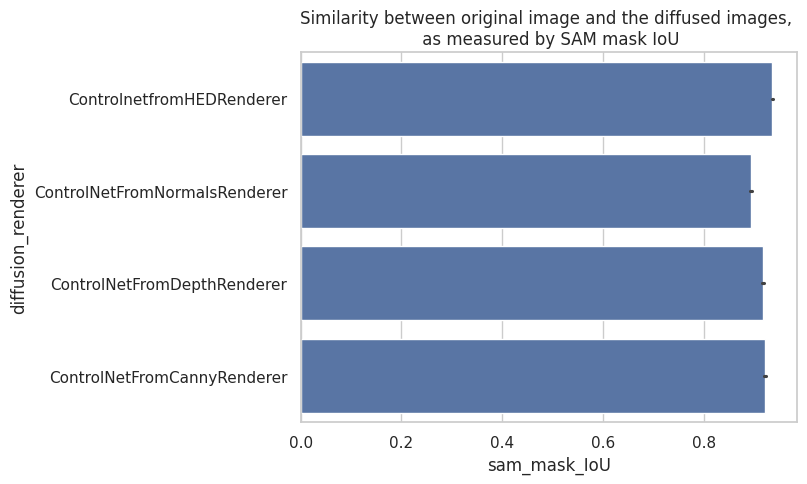

In [155]:
# plot the sam similarity for each renderer
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
ax = sns.barplot(y="diffusion_renderer", x="sam_mask_IoU", data=df)
ax.bar_label(ax.containers[0])
plt.title("Similarity between original image and the diffused images, \n as measured by SAM mask IoU")
plt.show()

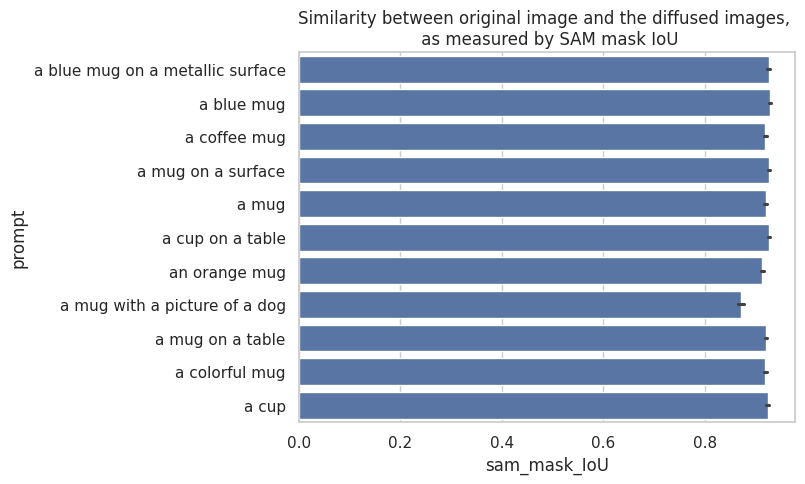

In [46]:
ax = sns.barplot(x="sam_mask_IoU", y="prompt", data=df)
plt.title("Similarity between original image and the diffused images, \n as measured by SAM mask IoU")
plt.show()

In [143]:
# group by the combination of mesh and render_id
# create new column that combines mesh and render_id
df["mesh_render_id"] = df["mesh"] + "_" + df["original_render_id"]
# group by this new column
df_grouped = df.groupby("mesh_render_id").mean(numeric_only=True)
df_grouped

# only get the N best and worst
N = 5
df_grouped = df_grouped.sort_values(by="sam_mask_IoU")
df_grouped_best = df_grouped[-N:]
df_grouped_worst = df_grouped[:N]

df_grouped_extremes = pandas.concat([df_grouped_best, df_grouped_worst])

Text(0.5, 1.0, 'Histogram of average similarities for the original images, \n averaged over all prompts and diffusion renderers')

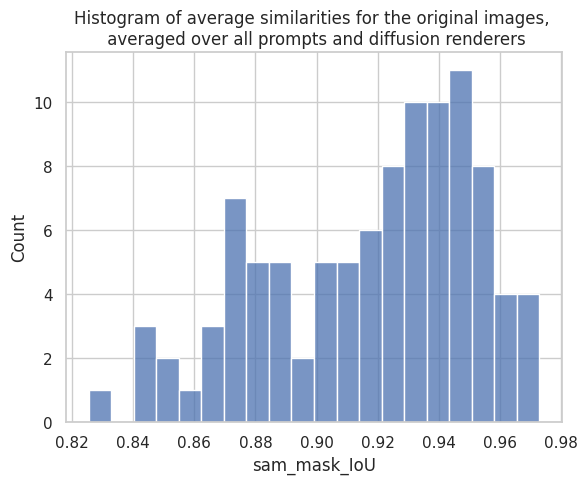

In [154]:
sns.set_theme(style="whitegrid")
ax = sns.histplot(x="sam_mask_IoU",data=df_grouped, bins=20)
plt.title("Histogram of average similarities for the original images, \n averaged over all prompts and diffusion renderers")

Text(0.5, 1.0, 'Similarity between original image and the diffused images for the five best and worst images')

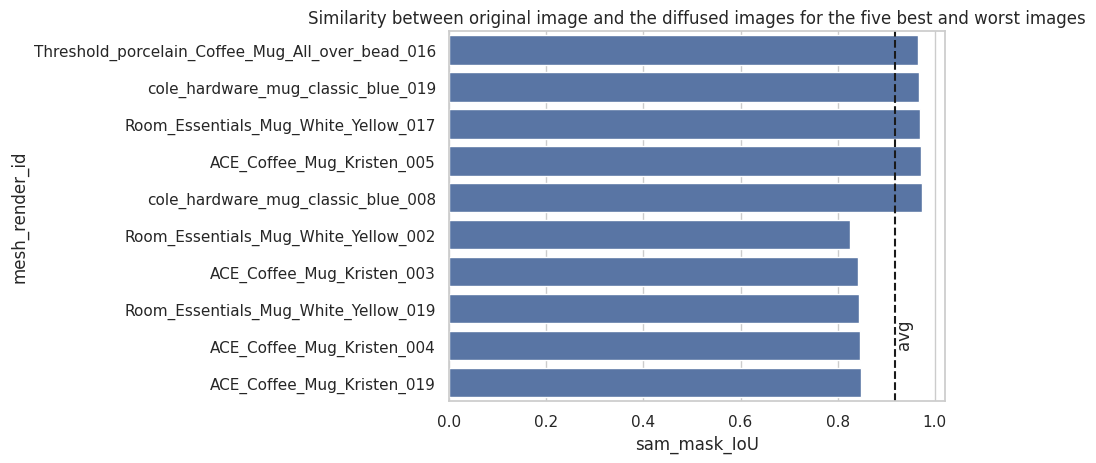

In [162]:
# plot the sam similarity for each
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
# show the distribution of sam mask IoU for each mesh
ax = sns.barplot(x="sam_mask_IoU", y="mesh_render_id", data=df_grouped_extremes)
# draw vertical line for the average
plt.axvline(x=df_grouped["sam_mask_IoU"].mean(), color='k', linestyle='--')
# add label to the vertical line
plt.text(df_grouped["sam_mask_IoU"].mean(), 8, "avg", rotation=90)
plt.title("Similarity between original image and the diffused images for the five best and worst images")


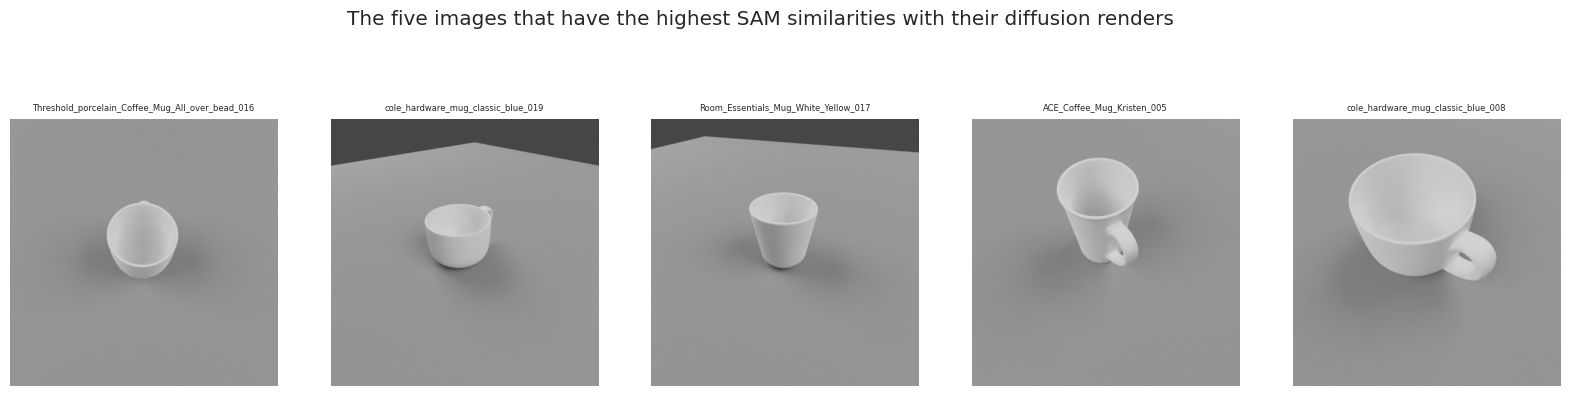

In [137]:
# show the five best rgb images
import matplotlib.pyplot as plt
from PIL import Image
fig, axes = plt.subplots(1, N, figsize=(20, 5))


for i, row in enumerate(df_grouped_best.iterrows()):
    mesh_render_id = row[0]
    relative_image_path = df[df["mesh_render_id"] == mesh_render_id]["relative_image_path"].iloc[0]
    image_path = render_dataset / relative_image_path
    original_image_path = image_path.parents[1] / "original" / "rgb.png"
    image = Image.open(original_image_path)
    axes[i].imshow(image)
    axes[i].set_title(row[0], fontsize=6)
    axes[i].axis("off")

plt.suptitle("The five images that have the highest SAM similarities with their diffusion renders")
plt.show()


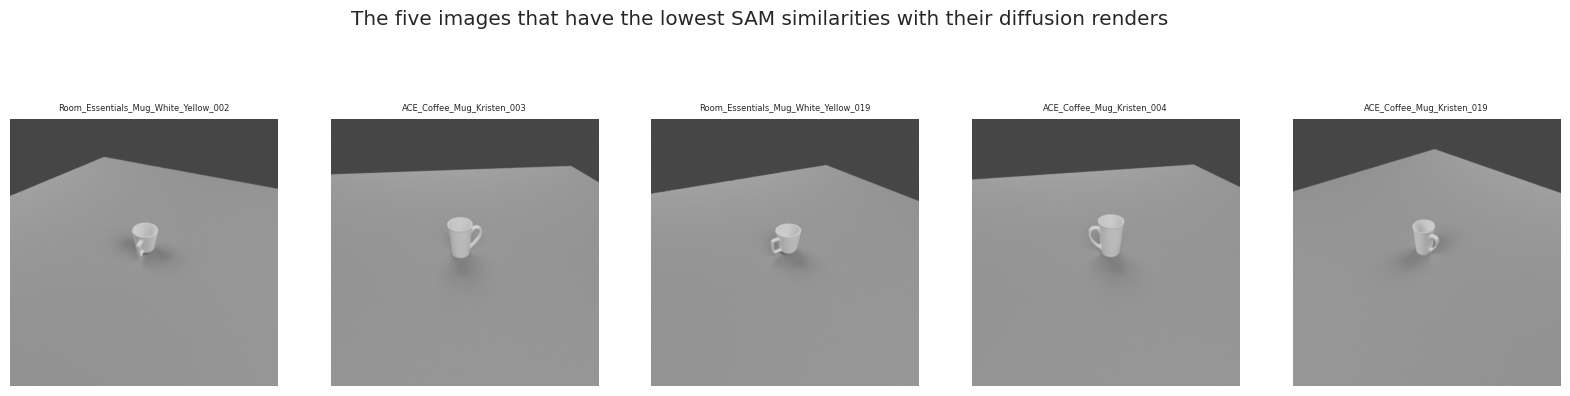

In [139]:
# show the five worst rgb images
import matplotlib.pyplot as plt
from PIL import Image
fig, axes = plt.subplots(1, N, figsize=(20, 5))
for i, row in enumerate(df_grouped_worst.iterrows()):
    mesh_render_id = row[0]
    relative_image_path = df[df["mesh_render_id"] == mesh_render_id]["relative_image_path"].iloc[0]
    image_path = render_dataset / relative_image_path
    original_image_path = image_path.parents[1] / "original" / "rgb.png"
    image = Image.open(original_image_path)
    axes[i].imshow(image)
    axes[i].set_title(row[0], fontsize=6)
    axes[i].axis("off")

plt.suptitle("The five images that have the lowest SAM similarities with their diffusion renders")

plt.show()